# Test Read Images from Zipfile
When extracting frames from rgb and optical flow videos, it is likely to exceed the file number limitation on many computing systems. Therefore, to reduce the file number and storage space, we archive the extracted frames into .zip files, and read images from the zip files during dataset loading for learning algorithm.

In [12]:
import zipfile
from PIL import Image
import shutil
import os
import numpy as np
from tqdm import tqdm

In [2]:
rgb_frame_root_dir = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb_frame/"
opt_frame_root_dir = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt_frame/"

In [3]:
rgb_frame_clip_zip_list = os.listdir(rgb_frame_root_dir)
rgb_frame_clip_zip_list.sort()

opt_frame_clip_zip_list = os.listdir(opt_frame_root_dir)
opt_frame_clip_zip_list.sort()
print('RGB: {}, OPT:{}'.format(len(rgb_frame_clip_zip_list), len(opt_frame_clip_zip_list)))

RGB: 18527, OPT:18527


In [65]:
for clip_zip_name in rgb_frame_clip_zip_list[:1]:
    print(clip_zip_name)
    rgb_clip_zip_path = os.path.join(rgb_frame_root_dir, clip_zip_name)
    opt_clip_zip_path = os.path.join(opt_frame_root_dir, clip_zip_name)
    
    # Read frames
    for i in range(5*25-20, 5*25+20):
        frame_name = 'image_{:06d}.jpg'.format(i)
        # Read rgb frames
        with zipfile.ZipFile(rgb_clip_zip_path) as rgb_clip_zip:
            rgb_img_f = rgb_clip_zip.open(frame_name)
            rgb_img = Image.open(rgb_img_f)
        # Read opt frames
        with zipfile.ZipFile(opt_clip_zip_path) as opt_clip_zip:
            opt_img_f = opt_clip_zip.open(frame_name)
            opt_img = Image.open(opt_img_f)

PassingEvent_Duration10s_000001.zip


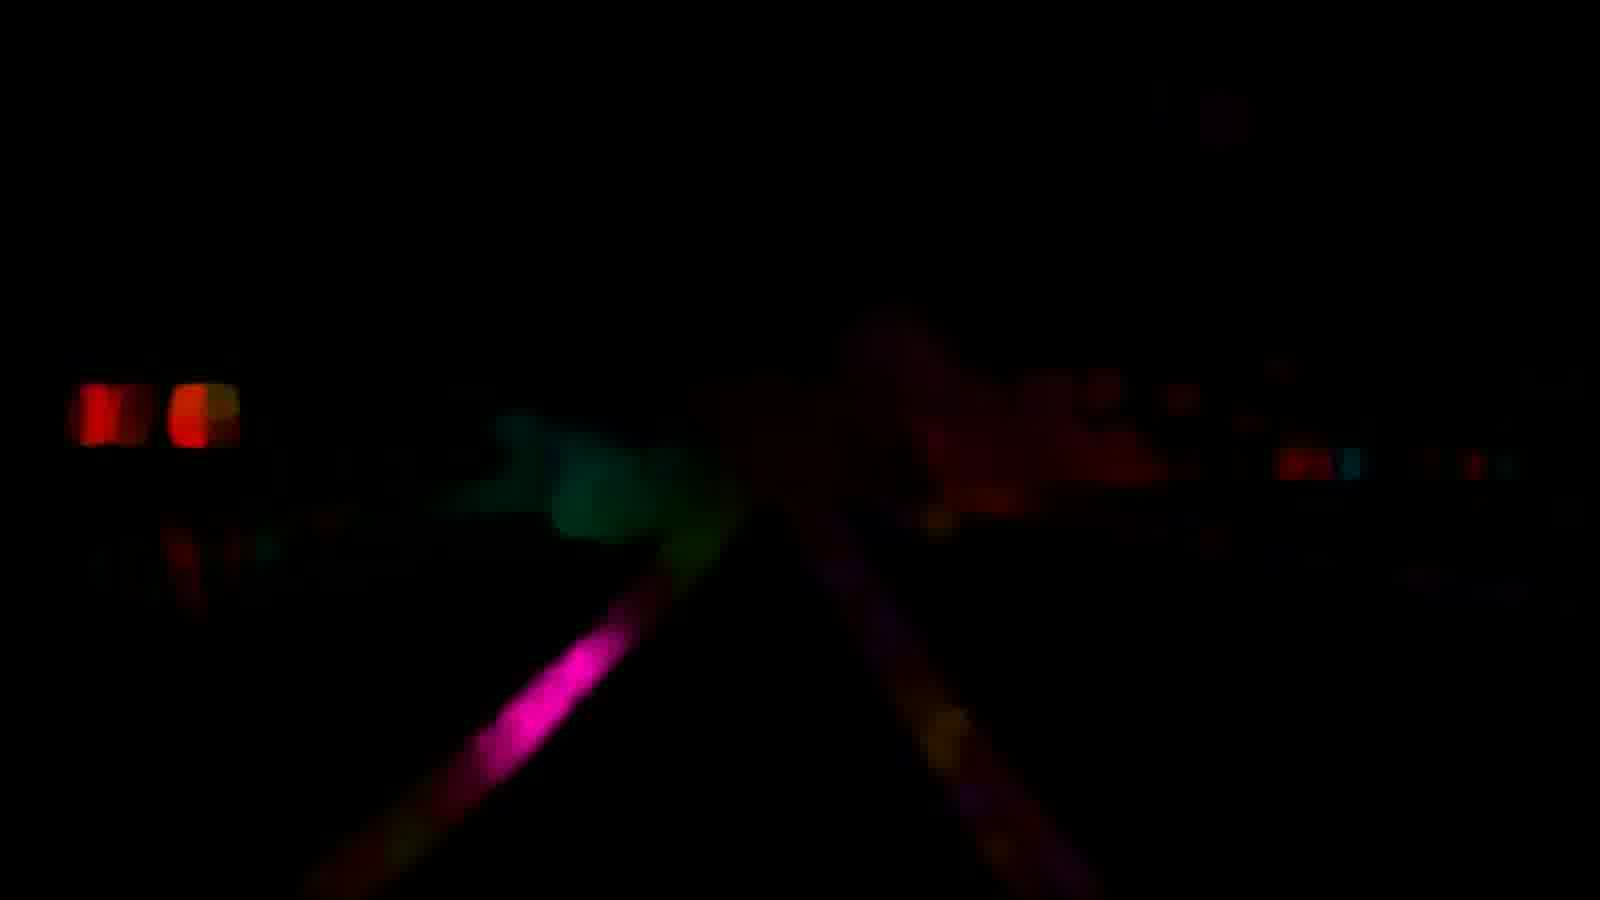

In [66]:
with zipfile.ZipFile(opt_clip_zip_path) as opt_clip_zip:
    opt_img_f = opt_clip_zip.open(frame_name)
    opt_img = Image.open(opt_img_f)
opt_img

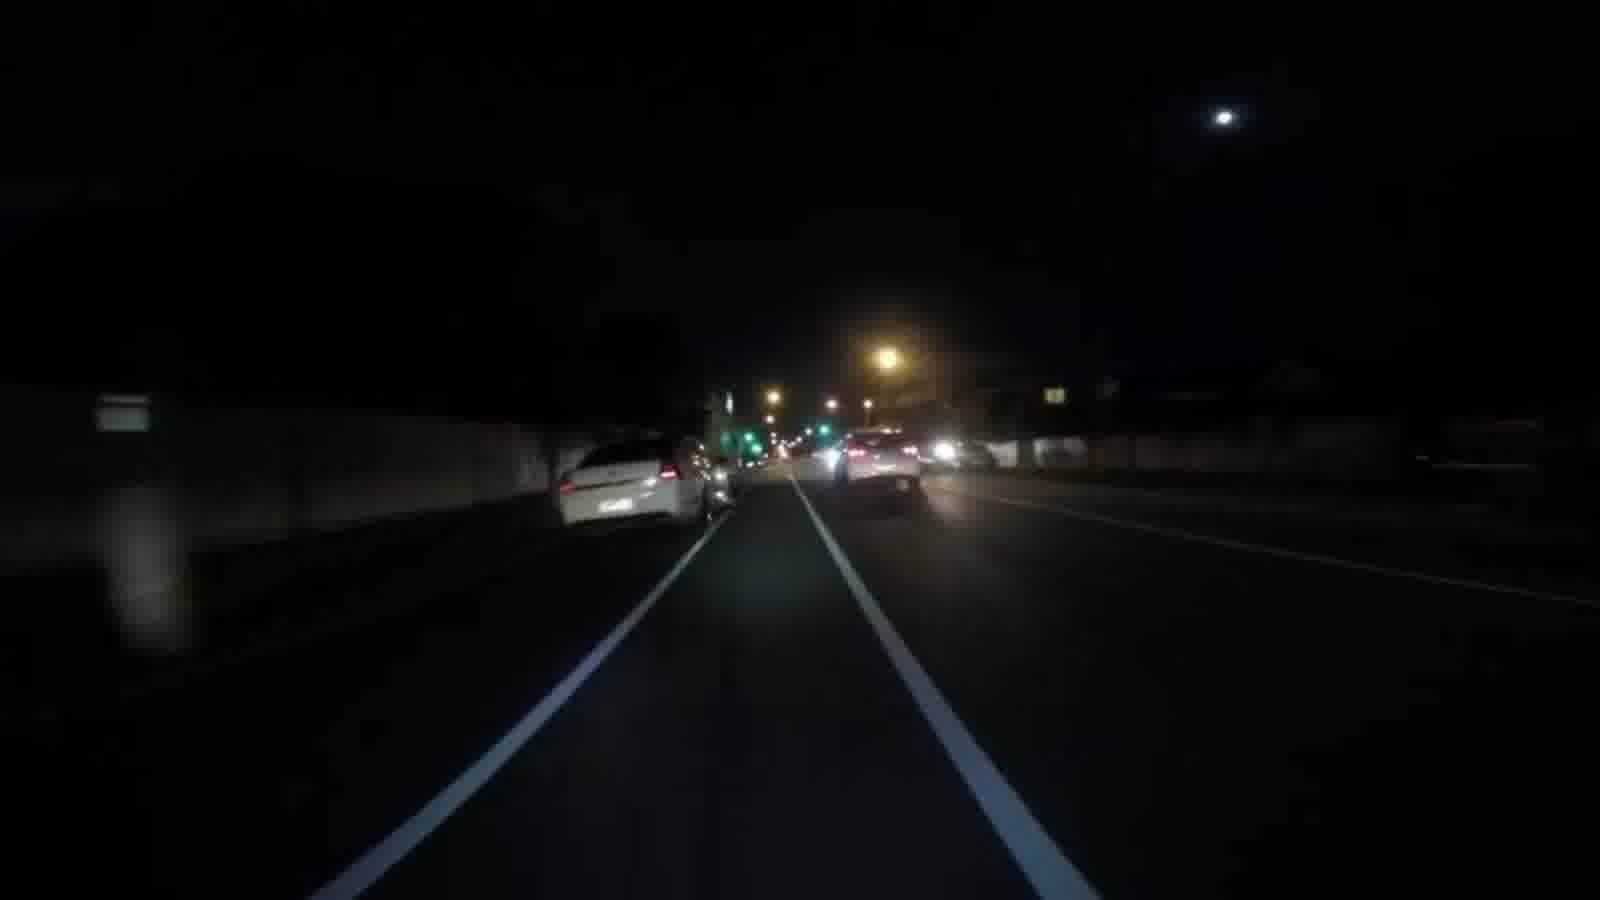

In [67]:
with zipfile.ZipFile(rgb_clip_zip_path) as rgb_clip_zip:
    rgb_img_f = rgb_clip_zip.open(frame_name)
    rgb_img = Image.open(rgb_img_f)
rgb_img

## Test fuse rgb and optical flow

In [18]:
rgb_frame_root_dir = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_rgb_frame/"
opt_frame_root_dir = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_opt_frame/"

fused_frame_root_dir = "/scratch/lingheng/cyc_safety_project/vic_cyc_legacy_pass_event_clip_fused_frame/"
if not os.path.exists(fused_frame_root_dir):
    os.makedirs(fused_frame_root_dir)
    
fuse_opt_num = 4    # The number of optical flow frames that will be fused with the current rgb frame


In [6]:
rgb_frame_clip_zip_list = os.listdir(rgb_frame_root_dir)
rgb_frame_clip_zip_list.sort()

opt_frame_clip_zip_list = os.listdir(opt_frame_root_dir)
opt_frame_clip_zip_list.sort()
print('RGB: {}, OPT:{}'.format(len(rgb_frame_clip_zip_list), len(opt_frame_clip_zip_list)))

RGB: 18527, OPT:18527


In [16]:
clip_zip_name.split('.')[0]

['PassingEvent_Duration10s_000003', 'zip']

In [20]:
process_start_id = 1
process_end_id = 2
for clip_zip_name in tqdm(rgb_frame_clip_zip_list[process_start_id: process_end_id]):
    fused_img_folder_name = clip_zip_name.split('.')[0]
    fused_img_folder_path = os.path.join(fused_frame_root_dir, fused_img_folder_name)
    if not os.path.exists(fused_img_folder_path):
        os.makedirs(fused_img_folder_path)
    print('Fusing {}'.format(clip_zip_name))
    rgb_clip_zip_path = os.path.join(rgb_frame_root_dir, clip_zip_name)
    opt_clip_zip_path = os.path.join(opt_frame_root_dir, clip_zip_name)
    
    # Read frames
    rgb_clip_zip = zipfile.ZipFile(rgb_clip_zip_path)
    opt_clip_zip = zipfile.ZipFile(opt_clip_zip_path)

    # List of frames of a video clip
    rgb_frame_list = rgb_clip_zip.namelist()
    rgb_frame_list.sort()

    opt_frame_list = opt_clip_zip.namelist()
    opt_frame_list.sort()

    # Get the maximum and minumum frame id 
    rgb_frame_min_id = int(rgb_frame_list[0].split('_')[1].split('.')[0])
    rgb_frame_max_id = int(rgb_frame_list[-1].split('_')[1].split('.')[0])
    opt_frame_min_id = int(opt_frame_list[0].split('_')[1].split('.')[0])
    opt_frame_max_id = int(opt_frame_list[-1].split('_')[1].split('.')[0])
    print('rgb_frame_min_id={}, opt_frame_min_id={}, rgb_frame_max_id={}, opt_frame_max_id={}'.format(rgb_frame_min_id, opt_frame_min_id, rgb_frame_max_id, opt_frame_max_id))

    # Check if rgb and opt frames have matched id
    if not (rgb_frame_min_id - opt_frame_min_id) == fuse_opt_num and rgb_frame_max_id == opt_frame_max_id:
        raise ValueError('RGB and OPT are not matched!')

    # Fuse
    for tmp_rgb_id in range(rgb_frame_min_id, rgb_frame_max_id+1):
        # Read the current rgb frame
        tmp_rgb_img_f = rgb_clip_zip.open('image_{:06d}.jpg'.format(tmp_rgb_id))
        tmp_rgb_img = Image.open(tmp_rgb_img_f)
        tmp_rgb_img_arr = np.array(tmp_rgb_img, dtype=float)
        # Read the current and the previous (fuse_opt_num-1) optical flow frames
        tmp_opt_list = []
        tmp_opt_arr_list = []
        for tmp_opt_id in range(tmp_rgb_id, tmp_rgb_id-fuse_opt_num, -1):
            tmp_opt_img_f = opt_clip_zip.open('image_{:06d}.jpg'.format(tmp_opt_id))
            tmp_opt_img = Image.open(tmp_opt_img_f)
            tmp_opt_img_arr = np.array(tmp_opt_img, dtype=float)
            tmp_opt_list.append(tmp_opt_img)
            tmp_opt_arr_list.append(tmp_opt_img_arr)
        # Average RGB and OPT frames
        opt_avg_arr = np.array(np.mean(tmp_opt_arr_list, axis=0), dtype=np.uint8)                  # Average optical flow
        fused_img_arr = np.array(np.mean([tmp_rgb_img_arr, opt_avg_arr], axis=0), dtype=np.uint8)  # Average rgb and opt
        fused_img = Image.fromarray(fused_img_arr)
        fused_img_path = os.path.join(fused_img_folder_path, 'image_{:06d}.jpg'.format(tmp_opt_id))
        fused_img.save(fused_img_path)
        print('Fused RGB: {}, and OPT: {}'.format(tmp_rgb_id, np.arange(tmp_rgb_id, tmp_rgb_id-fuse_opt_num, -1).tolist()))
    
    rgb_clip_zip.close()
    opt_clip_zip.close()
    
    # Archive to zip file
    fused_img_zip_file_path = os.path.join(fused_frame_root_dir, '{}'.format(fused_img_folder_name))
    shutil.make_archive(fused_img_zip_file_path, 'zip', fused_img_folder_path)
    shutil.rmtree(fused_img_folder_path)

  0%|          | 0/1 [00:00<?, ?it/s]

Fusing PassingEvent_Duration10s_000003.zip
rgb_frame_min_id=90, opt_frame_min_id=86, rgb_frame_max_id=144, opt_frame_max_id=144
Fused RGB: 90, and OPT: [90, 89, 88, 87]
Fused RGB: 91, and OPT: [91, 90, 89, 88]
Fused RGB: 92, and OPT: [92, 91, 90, 89]
Fused RGB: 93, and OPT: [93, 92, 91, 90]
Fused RGB: 94, and OPT: [94, 93, 92, 91]
Fused RGB: 95, and OPT: [95, 94, 93, 92]
Fused RGB: 96, and OPT: [96, 95, 94, 93]
Fused RGB: 97, and OPT: [97, 96, 95, 94]
Fused RGB: 98, and OPT: [98, 97, 96, 95]
Fused RGB: 99, and OPT: [99, 98, 97, 96]
Fused RGB: 100, and OPT: [100, 99, 98, 97]
Fused RGB: 101, and OPT: [101, 100, 99, 98]
Fused RGB: 102, and OPT: [102, 101, 100, 99]
Fused RGB: 103, and OPT: [103, 102, 101, 100]
Fused RGB: 104, and OPT: [104, 103, 102, 101]
Fused RGB: 105, and OPT: [105, 104, 103, 102]
Fused RGB: 106, and OPT: [106, 105, 104, 103]
Fused RGB: 107, and OPT: [107, 106, 105, 104]
Fused RGB: 108, and OPT: [108, 107, 106, 105]
Fused RGB: 109, and OPT: [109, 108, 107, 106]
Fused RG

100%|██████████| 1/1 [00:15<00:00, 15.95s/it]

Fused RGB: 144, and OPT: [144, 143, 142, 141]


In [70]:
rgb_clip_zip = zipfile.ZipFile(rgb_clip_zip_path)
opt_clip_zip = zipfile.ZipFile(opt_clip_zip_path)

In [96]:
rgb_clip_zip.namelist()

['image_000102.jpg',
 'image_000095.jpg',
 'image_000113.jpg',
 'image_000114.jpg',
 'image_000148.jpg',
 'image_000104.jpg',
 'image_000091.jpg',
 'image_000130.jpg',
 'image_000136.jpg',
 'image_000149.jpg',
 'image_000133.jpg',
 'image_000090.jpg',
 'image_000105.jpg',
 'image_000137.jpg',
 'image_000100.jpg',
 'image_000124.jpg',
 'image_000146.jpg',
 'image_000142.jpg',
 'image_000123.jpg',
 'image_000120.jpg',
 'image_000119.jpg',
 'image_000101.jpg',
 'image_000122.jpg',
 'image_000107.jpg',
 'image_000117.jpg',
 'image_000134.jpg',
 'image_000150.jpg',
 'image_000131.jpg',
 'image_000125.jpg',
 'image_000109.jpg',
 'image_000099.jpg',
 'image_000097.jpg',
 'image_000143.jpg',
 'image_000141.jpg',
 'image_000115.jpg',
 'image_000116.jpg',
 'image_000110.jpg',
 'image_000118.jpg',
 'image_000138.jpg',
 'image_000126.jpg',
 'image_000128.jpg',
 'image_000098.jpg',
 'image_000111.jpg',
 'image_000096.jpg',
 'image_000093.jpg',
 'image_000140.jpg',
 'image_000129.jpg',
 'image_00012

In [120]:


# List of frames of a video clip
rgb_frame_list = rgb_clip_zip.namelist()
rgb_frame_list.sort()

opt_frame_list = opt_clip_zip.namelist()
opt_frame_list.sort()

# Get en 
rgb_frame_min_id = int(rgb_frame_list[0].split('_')[1].split('.')[0])
rgb_frame_max_id = int(rgb_frame_list[-1].split('_')[1].split('.')[0])
opt_frame_min_id = int(opt_frame_list[0].split('_')[1].split('.')[0])
opt_frame_max_id = int(opt_frame_list[-1].split('_')[1].split('.')[0])
print('rgb_frame_min_id={}, opt_frame_min_id={}, rgb_frame_max_id={}, opt_frame_max_id={}'.format(rgb_frame_min_id, opt_frame_min_id, rgb_frame_max_id, opt_frame_max_id))

# Check if rgb and opt frames have matched id
if not (rgb_frame_min_id - opt_frame_min_id) == fuse_opt_num and rgb_frame_max_id == opt_frame_max_id:
    raise ValueError('RGB and OPT are not matched!')
    
# Fuse
for tmp_rgb_id in range(rgb_frame_min_id, rgb_frame_max_id+1):
    # Read the current rgb frame
    tmp_rgb_img_f = rgb_clip_zip.open('image_{:06d}.jpg'.format(tmp_rgb_id))
    tmp_rgb_img = Image.open(tmp_rgb_img_f)
    tmp_rgb_img_arr = np.array(tmp_rgb_img, dtype=float)
    # Read the current and the previous (fuse_opt_num-1) optical flow frames
    tmp_opt_list = []
    tmp_opt_arr_list = []
    for tmp_opt_id in range(tmp_rgb_id, tmp_rgb_id-fuse_opt_num, -1):
        tmp_opt_img_f = opt_clip_zip.open('image_{:06d}.jpg'.format(tmp_opt_id))
        tmp_opt_img = Image.open(tmp_opt_img_f)
        tmp_opt_img_arr = np.array(tmp_opt_img, dtype=float)
        tmp_opt_list.append(tmp_opt_img)
        tmp_opt_arr_list.append(tmp_opt_img_arr)
    # Average RGB and OPT frames
    opt_avg_arr = np.array(np.mean(tmp_opt_arr_list, axis=0), dtype=np.uint8)                  # Average optical flow
    fused_img_arr = np.array(np.mean([tmp_rgb_img_arr, opt_avg_arr], axis=0), dtype=np.uint8)  # Average rgb and opt
    fused_img = Image.fromarray(fused_img_arr)
    fused_img_path
    fused_img.save('image_{:06d}.jpg'.format(tmp_opt_id))
    print('Fused RGB: {}, and OPT: {}'.format(tmp_rgb_id, np.arange(tmp_rgb_id, tmp_rgb_id-fuse_opt_num, -1).tolist()))

rgb_frame_min_id=90, opt_frame_min_id=86, rgb_frame_max_id=150, opt_frame_max_id=150
Fused RGB: 90, and OPT: [90, 89, 88, 87]
Fused RGB: 91, and OPT: [91, 90, 89, 88]
Fused RGB: 92, and OPT: [92, 91, 90, 89]
Fused RGB: 93, and OPT: [93, 92, 91, 90]
Fused RGB: 94, and OPT: [94, 93, 92, 91]
Fused RGB: 95, and OPT: [95, 94, 93, 92]
Fused RGB: 96, and OPT: [96, 95, 94, 93]
Fused RGB: 97, and OPT: [97, 96, 95, 94]
Fused RGB: 98, and OPT: [98, 97, 96, 95]
Fused RGB: 99, and OPT: [99, 98, 97, 96]
Fused RGB: 100, and OPT: [100, 99, 98, 97]
Fused RGB: 101, and OPT: [101, 100, 99, 98]
Fused RGB: 102, and OPT: [102, 101, 100, 99]
Fused RGB: 103, and OPT: [103, 102, 101, 100]
Fused RGB: 104, and OPT: [104, 103, 102, 101]
Fused RGB: 105, and OPT: [105, 104, 103, 102]
Fused RGB: 106, and OPT: [106, 105, 104, 103]
Fused RGB: 107, and OPT: [107, 106, 105, 104]
Fused RGB: 108, and OPT: [108, 107, 106, 105]
Fused RGB: 109, and OPT: [109, 108, 107, 106]
Fused RGB: 110, and OPT: [110, 109, 108, 107]
Fused

In [136]:
fused_img.save('test_fused_img.jpg')

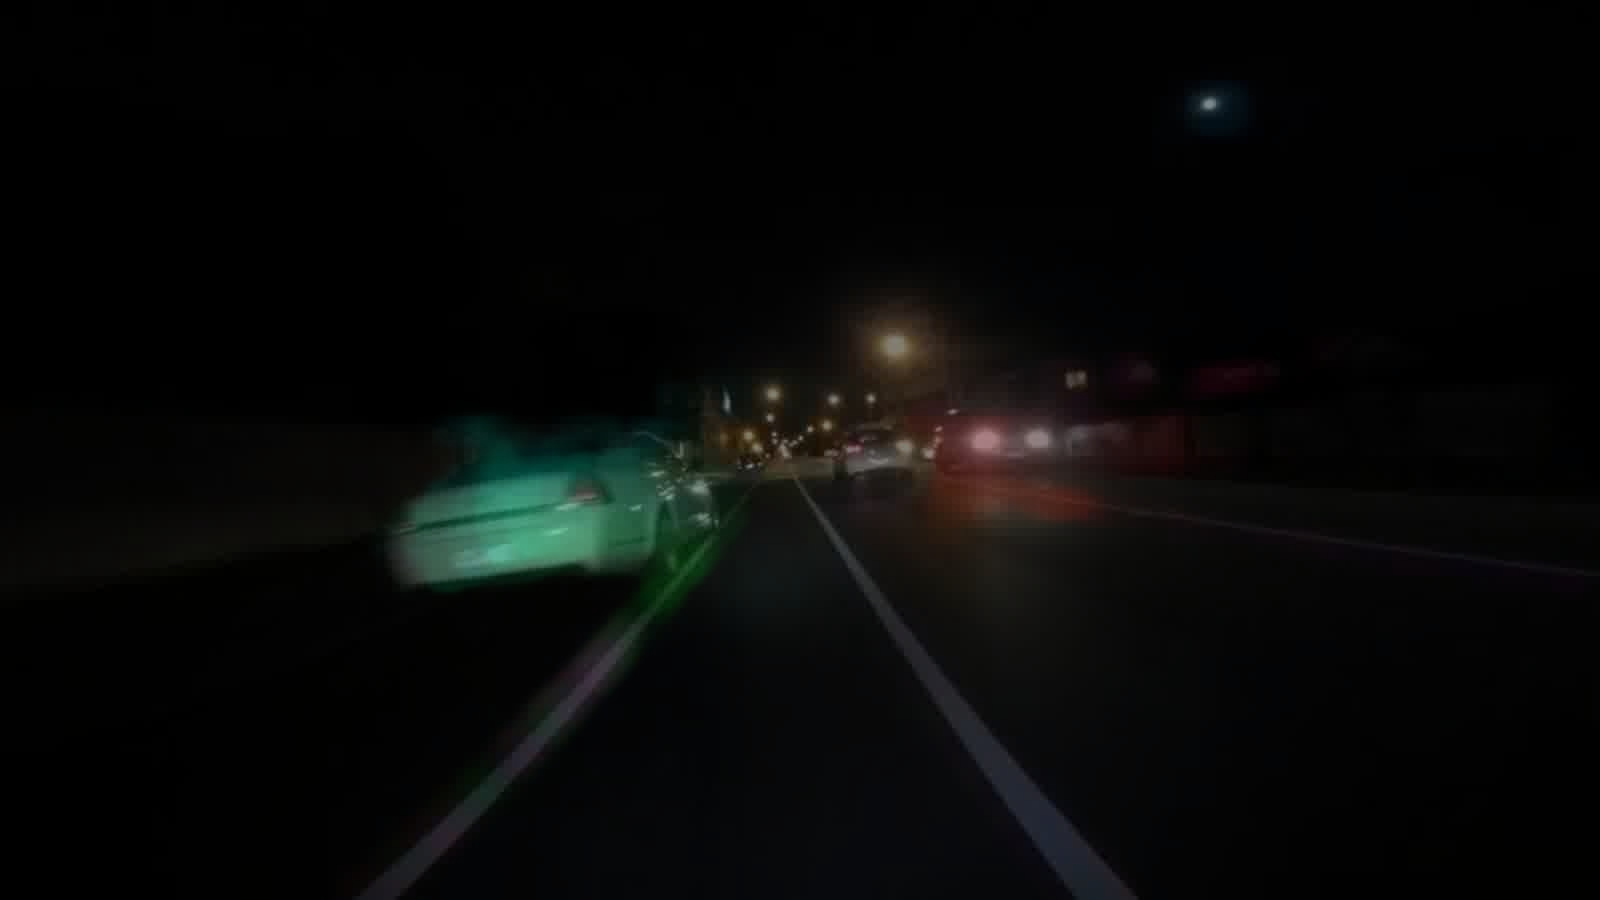

In [135]:
fused_img_arr = np.array(np.mean([tmp_rgb_img_arr, opt_avg_arr], axis=0), dtype=np.uint8)
fused_img = Image.fromarray(fused_img_arr)
fused_img

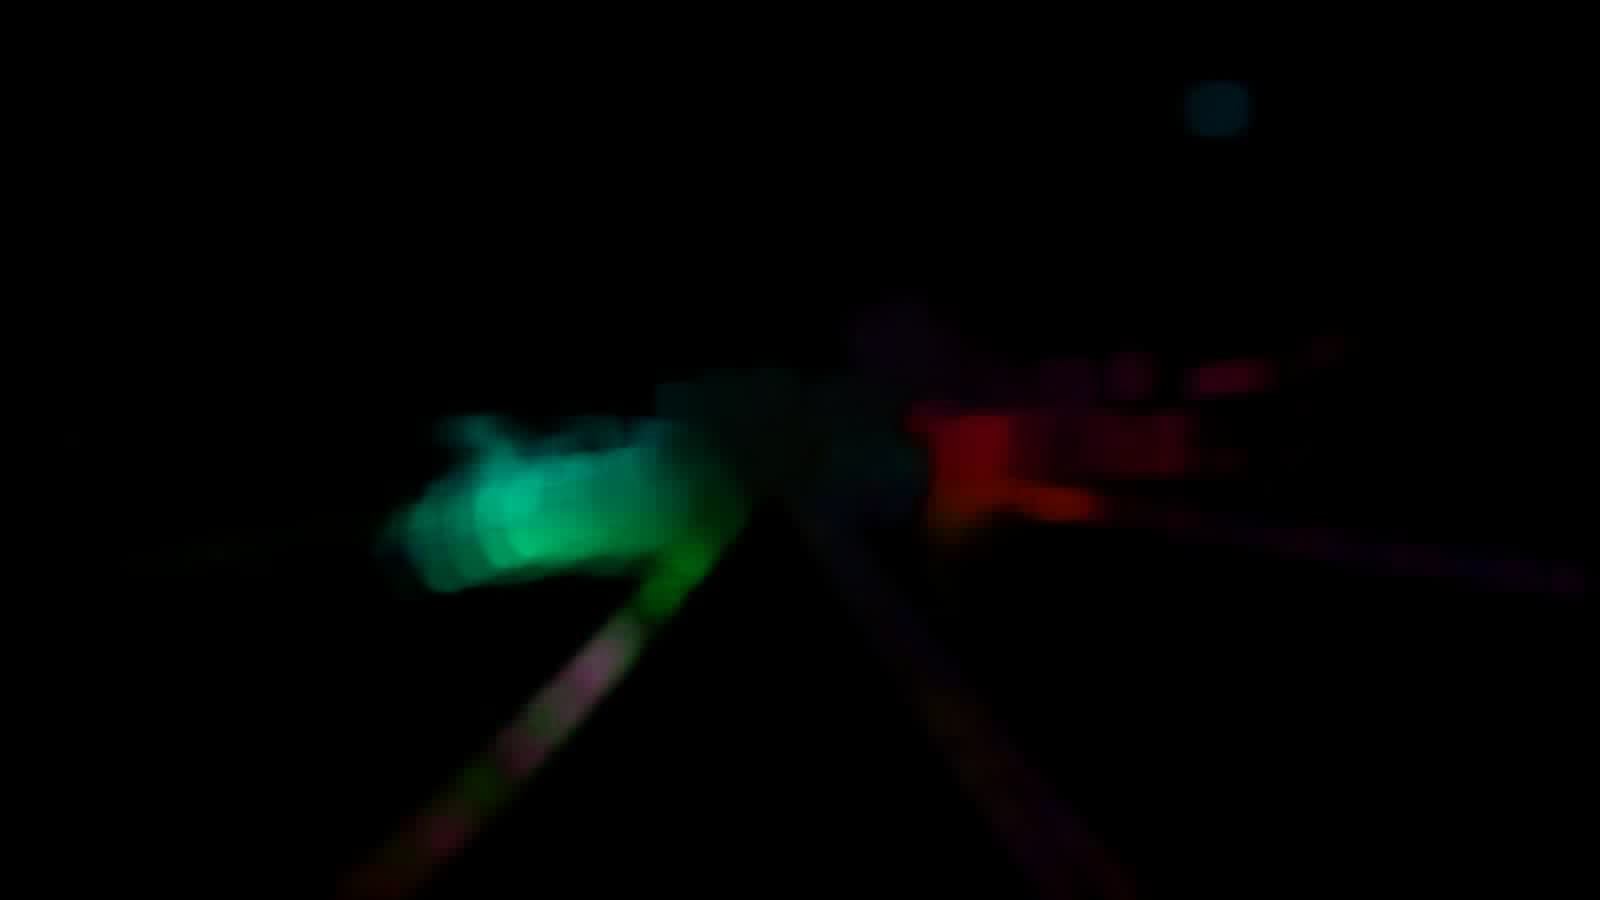

In [132]:
opt_avg_arr = np.array(np.mean(tmp_opt_arr_list, axis=0), dtype=np.uint8)
img = Image.fromarray(opt_avg_arr)
img

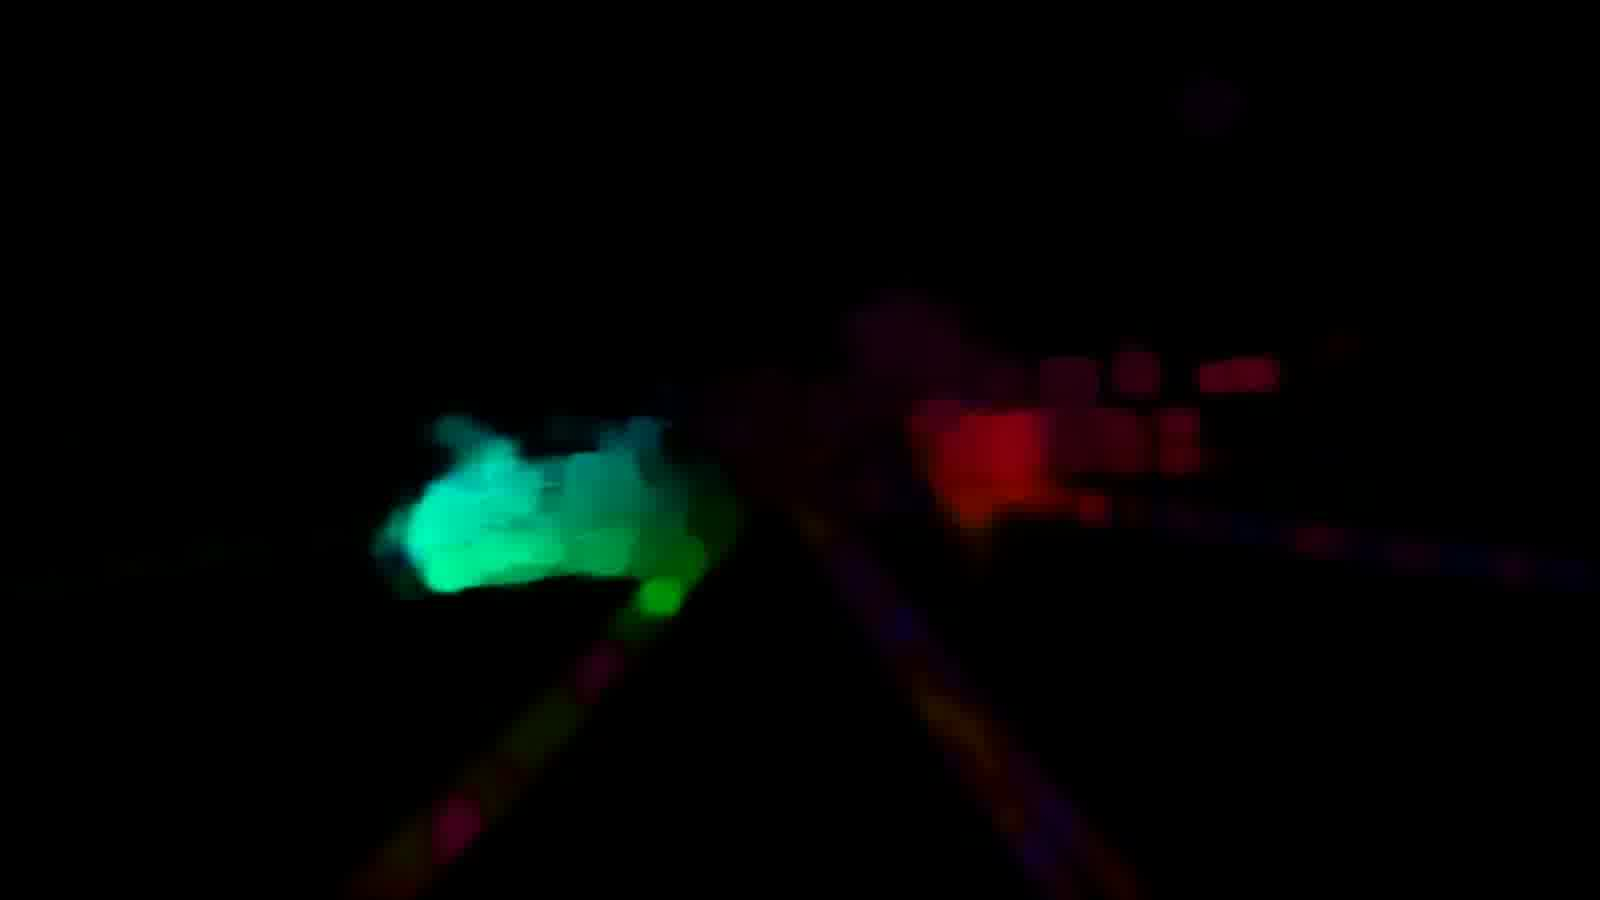

In [108]:
tmp_opt_list[0]